# Lipid(%) 预测完整流程

**流程**: 数据增广 → 异常值处理 → Z-Score标准化 → 随机森林模型训练

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. 配置参数

In [15]:
# 路径配置
DATA_PATH = "data/raw/row_data.xlsx"
OUTPUT_DIR = "data/augmentdata"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 目标列
TARGET_COL = "lipid(%)"

# lipid(%) 四分位分层区间
LIPID_BINS = [-np.inf, 1.207250, 2.998121, 8.880500, np.inf]
LIPID_LABELS = [0, 1, 2, 3]

# 增广倍数
AUGMENT_MULTIPLIER = 5

# 噪声参数表：列名 -> (min, max, sigma)
NOISE_PARAMS = {
    "pH ": (7.4400, 9.9300, 0.048402),
    "DO": (7.2100, 20.8100, 0.254980),
    "COD": (7.5600, 70.4000, 1.208530),
    "BOD": (0.5000, 17.0000, 0.360543),
    "Total photosynthetic pigments": (0.0631, 2.5140, 0.050577),
    "Dry cell weight": (4.8100, 111.7000, 2.081404),
    "protein(%)": (0.2370, 19.1200, 0.477062),
    "H(%)": (3.2135, 12.8440, 0.175078),
    "O(%)": (24.8353, 41.7935, 0.278331),
}

# 百分比列
PERCENT_COLS = ["protein(%)", "H(%)", "O(%)"]

# 特征列
FEATURE_COLS = ["pH ", "DO", "COD", "BOD", "Total photosynthetic pigments",
                "Dry cell weight", "protein(%)", "H(%)", "O(%)"]

## 2. 数据增广

In [16]:
# 加载原始数据
df = pd.read_excel(DATA_PATH)
print(f"原始数据形状: {df.shape}")

原始数据形状: (36, 10)


In [17]:
def create_lipid_strata(df):
    """根据 lipid(%) 创建分层标签"""
    return pd.cut(df[TARGET_COL], bins=LIPID_BINS, labels=LIPID_LABELS)


def stratified_split(df, test_size=0.2):
    """分层切分训练测试集"""
    strata = create_lipid_strata(df)
    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=strata, random_state=42
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


def add_gaussian_noise(row, noise_cols):
    """对单行数据的指定列添加高斯噪声"""
    noisy_row = row.copy()
    for col in noise_cols:
        if col in NOISE_PARAMS:
            min_val, max_val, sigma = NOISE_PARAMS[col]
            noise = np.random.normal(0, sigma)
            new_val = np.clip(row[col] + noise, min_val, max_val)
            if col in PERCENT_COLS:
                new_val = np.clip(new_val, 0, 100)
            noisy_row[col] = new_val
    return noisy_row


def augment_stratum(stratum_df, target_count, noise_cols):
    """对单个分层区间进行增广"""
    original_count = len(stratum_df)
    augment_count = target_count - original_count
    if augment_count <= 0:
        return stratum_df
    
    sampled_indices = np.random.choice(stratum_df.index, size=augment_count, replace=True)
    sampled_rows = stratum_df.loc[sampled_indices]
    augmented_rows = [add_gaussian_noise(row, noise_cols) for _, row in sampled_rows.iterrows()]
    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([stratum_df, augmented_df], ignore_index=True)


def augment_training_data(train_df):
    """对训练集进行分层增广"""
    noise_cols = list(NOISE_PARAMS.keys())
    train_df = train_df.copy()
    train_df["_strata"] = create_lipid_strata(train_df)
    
    augmented_strata = []
    for stratum_label in LIPID_LABELS:
        stratum_df = train_df[train_df["_strata"] == stratum_label].drop(columns=["_strata"])
        original_count = len(stratum_df)
        target_count = original_count * AUGMENT_MULTIPLIER
        print(f"分层 {stratum_label}: {original_count} -> {target_count}")
        augmented_strata.append(augment_stratum(stratum_df.reset_index(drop=True), target_count, noise_cols))
    
    return pd.concat(augmented_strata, ignore_index=True)

In [18]:
# 执行分层切分和增广
train_df, test_df = stratified_split(df, test_size=0.2)
print(f"训练集: {train_df.shape}, 测试集: {test_df.shape}\n")

augmented_train = augment_training_data(train_df)
augmented_train = augmented_train.drop_duplicates().sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\n增广后训练集: {augmented_train.shape}")

训练集: (28, 10), 测试集: (8, 10)

分层 0: 7 -> 35
分层 1: 7 -> 35
分层 2: 7 -> 35
分层 3: 7 -> 35

增广后训练集: (140, 10)


## 3. 异常值处理（盖帽法）

In [19]:
IQR_MULTIPLIER = 1.5

def cap_outliers_iqr(df, columns, multiplier=1.5):
    """使用 IQR 盖帽法处理异常值"""
    df_capped = df.copy()
    total_capped = 0
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        capped_count = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()
        total_capped += capped_count
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"总计盖帽处理: {total_capped} 个值")
    return df_capped

train_cleaned = cap_outliers_iqr(augmented_train, FEATURE_COLS, IQR_MULTIPLIER)
print(f"异常值处理后训练集: {train_cleaned.shape}")

总计盖帽处理: 30 个值
异常值处理后训练集: (140, 10)


## 4. Z-Score 标准化

In [20]:
# 去除列名空格
train_cleaned.columns = train_cleaned.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

FEATURE_COLS_CLEAN = [c.strip() for c in FEATURE_COLS]

# 标准化
scaler = StandardScaler()
train_normalized = train_cleaned.copy()
train_normalized[FEATURE_COLS_CLEAN] = scaler.fit_transform(train_cleaned[FEATURE_COLS_CLEAN])

test_normalized = test_df.copy()
test_normalized[FEATURE_COLS_CLEAN] = scaler.transform(test_df[FEATURE_COLS_CLEAN])

print(f"标准化后训练集: {train_normalized.shape}")
print(f"标准化后测试集: {test_normalized.shape}")

# 保存标准化参数
scaler_params = pd.DataFrame({
    'feature': FEATURE_COLS_CLEAN,
    'mean': scaler.mean_,
    'std': scaler.scale_
})
print("\n标准化参数:")
scaler_params

标准化后训练集: (140, 10)
标准化后测试集: (8, 10)

标准化参数:


,feature,mean,std
0,pH,8.546758,0.578936
1,DO,10.323049,3.086983
2,COD,25.133025,11.652745
3,BOD,4.899440,4.422300
4,Total photosynthetic pigments,0.560127,0.343348
5,Dry cell weight,38.394849,18.785208
6,protein(%),6.853053,6.349580
7,H(%),8.576125,1.908526
8,O(%),35.444459,3.069285


## 5. 随机森林模型训练

In [21]:
# 准备数据
X_train = train_normalized[FEATURE_COLS_CLEAN]
y_train = train_normalized[TARGET_COL]
X_test = test_normalized[FEATURE_COLS_CLEAN]
y_test = test_normalized[TARGET_COL]

print(f'训练集: {X_train.shape[0]} 样本, {X_train.shape[1]} 特征')
print(f'测试集: {X_test.shape[0]} 样本, {X_test.shape[1]} 特征')

训练集: 140 样本, 9 特征
测试集: 8 样本, 9 特征


In [22]:
# 使用 GridSearchCV 进行 5 折交叉验证超参数调优
param_grid = {
    'n_estimators': [60, 80, 100],
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt']
}

# 基础模型
base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV: 在训练集内部进行 5 折交叉验证
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# 在训练集上进行交叉验证调参
grid_search.fit(X_train, y_train)

# 最佳模型和参数
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_r2 = grid_search.best_score_

print(f'\n5 折交叉验证最佳 R²: {best_cv_r2:.4f}')
print('最佳参数:', best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

5 折交叉验证最佳 R²: 0.8698
最佳参数: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


## 6. 模型评估

In [23]:
# 使用交叉验证预测结果评估训练集性能
y_train_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_test_pred = best_model.predict(X_test)

print('训练集 (5 折交叉验证):')
print(f'  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_cv_pred)):.4f}')
print(f'  MAE:  {mean_absolute_error(y_train, y_train_cv_pred):.4f}')
print(f'  R²:   {r2_score(y_train, y_train_cv_pred):.4f}')
print('\n测试集:')
print(f'  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}')
print(f'  MAE:  {mean_absolute_error(y_test, y_test_pred):.4f}')
print(f'  R²:   {r2_score(y_test, y_test_pred):.4f}')

训练集 (5 折交叉验证):
  RMSE: 1.8256
  MAE:  1.2313
  R²:   0.8692

测试集:
  RMSE: 3.2956
  MAE:  2.7258
  R²:   0.4362


特征重要性:

                      feature  importance
                         O(%)    0.261120
                           DO    0.150494
                         H(%)    0.133328
                          BOD    0.127874
              Dry cell weight    0.089896
                   protein(%)    0.078925
Total photosynthetic pigments    0.065804
                           pH    0.064465
                          COD    0.028094


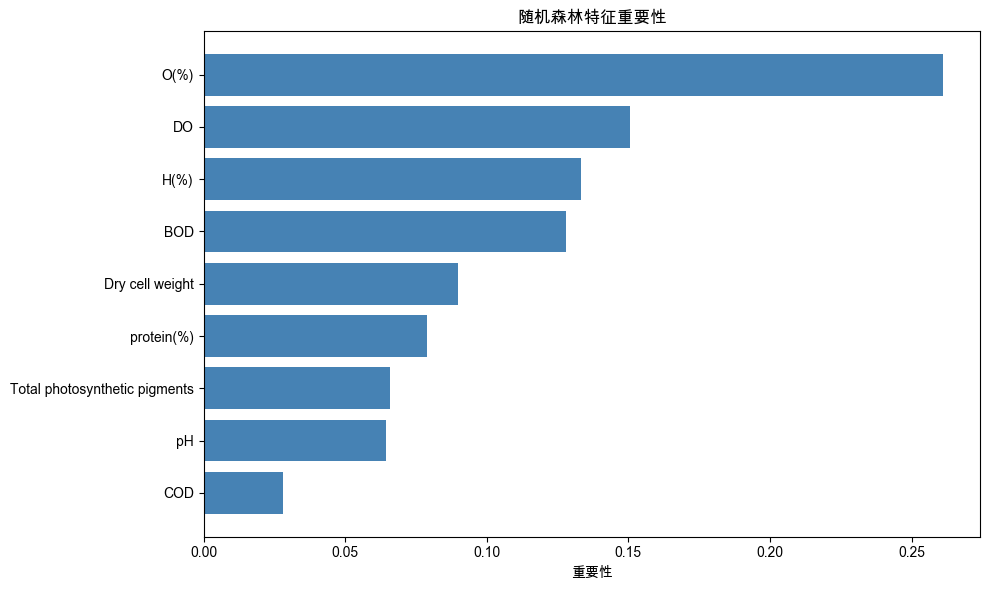

In [24]:
# 特征重要性
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS_CLEAN,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print('特征重要性:\n')
print(feature_importance.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
ax.set_xlabel('重要性')
ax.set_title('随机森林特征重要性')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

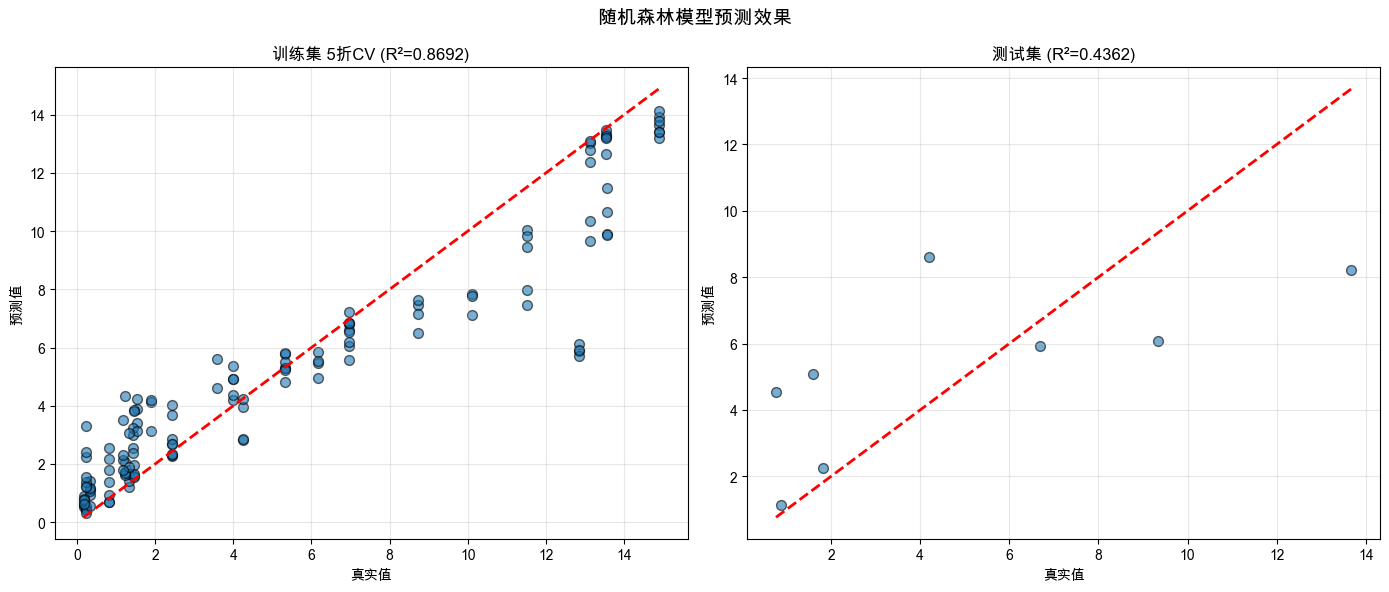

In [25]:
# 预测效果可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, y_true, y_pred, title in [
    (axes[0], y_train, y_train_cv_pred, f'训练集 5折CV (R²={r2_score(y_train, y_train_cv_pred):.4f})'),
    (axes[1], y_test, y_test_pred, f'测试集 (R²={r2_score(y_test, y_test_pred):.4f})')
]:
    ax.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=50)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_xlabel('真实值')
    ax.set_ylabel('预测值')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.suptitle('随机森林模型预测效果', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
# 测试集预测详情
test_results = pd.DataFrame({
    '真实值': y_test.values,
    '预测值': y_test_pred,
    '误差': y_test.values - y_test_pred,
    '绝对误差': np.abs(y_test.values - y_test_pred)
})
print('测试集预测详情:\n')
test_results

测试集预测详情:



,真实值,预测值,误差,绝对误差
0,6.690000,5.923554,0.766446,0.766446
1,9.347000,6.088776,3.258224,3.258224
2,0.766912,4.534249,-3.767337,3.767337
3,0.881452,1.133195,-0.251743,0.251743
4,1.587000,5.083966,-3.496966,3.496966
5,4.208457,8.597168,-4.388711,4.388711
6,1.822245,2.244091,-0.421846,0.421846
7,13.674000,8.218651,5.455349,5.455349
